In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv("/content/FINAL_DATA2.csv")
df.cleanData=df.cleanData.astype(str)

In [ ]:
#df['word_length'] = df['cleanData'].apply(lambda x:len(x.split()))
df.dtypes

twitter_id             int64
content               object
location              object
search_word            int64
word_length            int64
cleanData             object
location_extracted    object
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.cleanData,df.search_word, test_size = 0.2, stratify = df.search_word,random_state = 42)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
len(tokenizer.word_index)

3664

In [ ]:
df.word_length.max()

28

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(1969, 171) (493, 171)


In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
glove_gensim['cat'].shape[0]

300

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
print(gensim_weight_matrix.shape)
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,GRU
import tensorflow
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

(10000, 300)


In [ ]:

EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(300,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(GRU(300,return_sequences=False)))
model_gensim.add(Dense(3, activation = 'softmax'))
model_gensim.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',metrics =['accuracy'])

In [ ]:
model_gensim.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 171, 300)          3000000   
                                                                 
 dropout_13 (Dropout)        (None, 171, 300)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 171, 600)         1083600   
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 171, 600)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 171, 800)         2404800   
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 171, 800)         

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 60, batch_size = 200, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/60
10/10 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8202
Epoch 00001: val_accuracy improved from -inf to 0.91684, saving model to ./model_gensim.h5
10/10 [==============================] - 34s 2s/step - loss: 0.4357 - accuracy: 0.8202 - val_loss: 0.2975 - val_accuracy: 0.9168
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9401
Epoch 00002: val_accuracy improved from 0.91684 to 0.94523, saving model to ./model_gensim.h5
10/10 [==============================] - 17s 2s/step - loss: 0.2026 - accuracy: 0.9401 - val_loss: 0.2252 - val_accuracy: 0.9452
Epoch 3/60
10/10 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9584
Epoch 00003: val_accuracy did not improve from 0.94523
10/10 [==============================] - 17s 2s/step - loss: 0.1260 - accuracy: 0.9584 - val_loss: 0.2397 - val_accuracy: 0.9412
Epoch 4/60
10/10 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.96

In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

16/16 [==============================] - 3s 194ms/step - loss: 0.3116 - accuracy: 0.9493


[0.31164538860321045, 0.9492900371551514]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

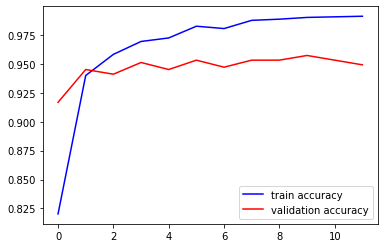

In [ ]:
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

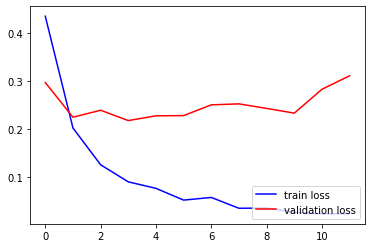

In [ ]:
plt.plot(history_gensim.history['loss'],c='b',label='train loss')
plt.plot(history_gensim.history['val_loss'],c='r',label='validation loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
new_complaint = ['There is too much traffic on road which has caused jam from sector 32 to sector 36']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=171,padding='post')
pred = model_gensim.predict(padded)
labels = ['Accident','Traffic','Potholes']
print(pred, labels[np.argmax(pred)])

[[1.6940332e-05 9.9998271e-01 3.2241144e-07]] Traffic


In [ ]:
from sklearn.metrics import classification_report

y_pred=model_gensim.predict(X_test_pad)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)


              precision    recall  f1-score   support

           0       0.87      0.79      0.83        66
           1       0.96      0.99      0.97       418
           2       1.00      0.44      0.62         9

    accuracy                           0.95       493
   macro avg       0.94      0.74      0.80       493
weighted avg       0.95      0.95      0.95       493

